In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import shapely as shp
%matplotlib inline

# The final product will look like that

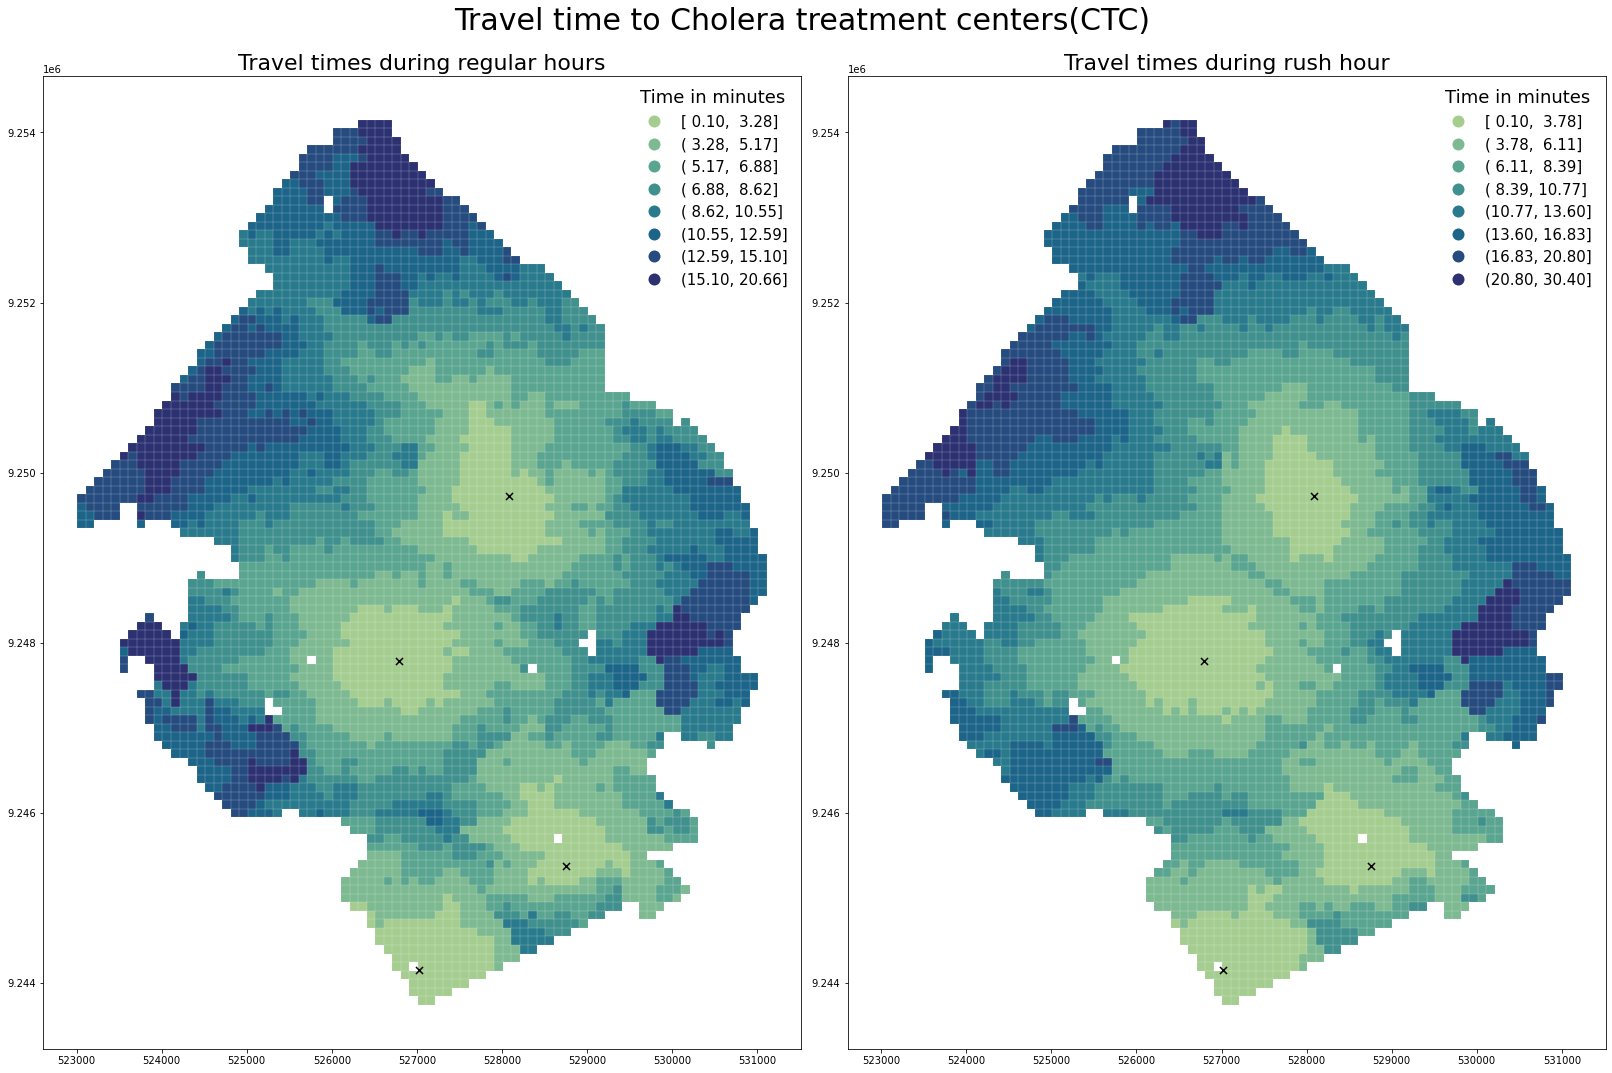

In [114]:
fig, ax = plt.subplots(1,2, figsize = (1.5*15,1.5*10))

#plot the first one
grid.loc[grid.tt_ctc==9999].plot(ax=ax[0], color = 'w')
grid.loc[grid.tt_ctc!=9999].plot(ax=ax[0] ,column = 'tt_ctc',
                                 scheme = 'naturalbreaks', k = 8,cmap = 'crest',
                                 legend = True, legend_kwds =  {'fontsize':15,'title_fontsize': 18,
                                                               'title': 'Time in minutes', 'markerscale':1.2,
                                                               'frameon' : False})
grid.plot(ax=ax[0] , facecolor = 'None',edgecolor = 'w', linewidth=0.1)
ctc.plot(ax=ax[0] , color = 'k', marker = 'x', markersize = 50)

#plot the second one
grid.loc[grid.tt_ctc==9999].plot(ax=ax[1], color = 'w')
grid.loc[grid.tt_ctc!=9999].plot(ax=ax[1] ,column = 'tt_ctc_tra',
                                 scheme = 'naturalbreaks', k = 8, cmap = 'crest',
                                 legend = True, legend_kwds = {'fontsize':15,'title_fontsize': 18,
                                                               'title': 'Time in minutes', 'markerscale':1.2,
                                                               'frameon' : False})
grid.plot(ax=ax[1] , facecolor = 'None',edgecolor = 'w', linewidth=0.1)
ctc.plot(ax=ax[1] , color = 'k', marker = 'x', markersize = 50)

fig.suptitle("Travel time to Cholera treatment centers(CTC) \n ", fontsize=1.5*20)
ax[0].set_title('Travel times during regular hours', fontsize=22)
ax[1].set_title('Travel times during rush hour', fontsize=22)

plt.tight_layout()
plt.savefig('./output/jpg/03.jpg', dpi=150)

# Now here is the process

### Preparing the roadnetwork dataset
### We want to calculate the travel time per street segment and add it to the road dataset 

In [4]:
streets = gpd.read_file('./output/json/nx_test/streets_betweenness.shp')

<AxesSubplot:>

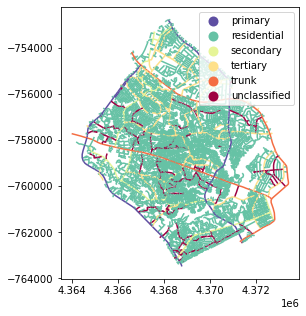

In [17]:
streets.plot(figsize = (5,5), column = 'highway', categorical = True, cmap = 'Spectral_r', legend = True)

In [34]:
streets.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [21]:
streets.highway.value_counts()

residential     13485
unclassified      869
tertiary          832
secondary         433
primary           320
trunk             247
Name: highway, dtype: int64

In [49]:
# from a working paper published by world bank in march 2020 (Policy Research Working Paper 9185)
#travel times are classifies based on two main classification of roads primary and secondary
#The median speed for primary roads ranges from 31 to 45 km/h depending on the traffic
# in our approach we will assume that the secondary roads will always work on it's maximum speed which is 24 km/h

In [50]:
# first we make a mask to separate primary and secondary roads

In [5]:
primary_mask = streets.to_crs(roads.crs).loc[(streets.highway != 'residential') &
            (streets.highway != 'secondary') &
            (streets.highway != 'unclassified'),'geometry'].buffer(2).unary_union

In [6]:
primary_mask_l = streets.to_crs(roads.crs).loc[(streets.highway != 'residential') &
            (streets.highway != 'secondary') &
            (streets.highway != 'unclassified'),'geometry'].buffer(30).unary_union

In [11]:
# Now we will add the speed per each road in km/h
# Will add also the secondary roads surrounding the main roads to be slightly congested according to google maps traffic data
# this will make these roads with a speed of 16kmh

In [7]:
roads['kmh_max'] = 24
roads['kmh_min'] = 24

In [8]:
roads.loc[roads.geometry.within(primary_mask), 'kmh_max'] = 45

In [9]:
roads.loc[roads.geometry.intersects(primary_mask_l), 'kmh_min'] = 16

In [10]:
roads.loc[roads.kmh_max == 45, 'kmh_min'] = 31

In [17]:
roads.head()

,highway,len,straightne,betweennes,geometry,kmh_max,kmh_min
0,primary,19.061221,0.891534,1.008051e-07,"LINESTRING (523848.099 9247293.270, 523866.003...",45,31
1,residential,13.528092,0.904029,1.764088e-07,"LINESTRING (523866.003 9247299.812, 523877.597...",24,16
2,residential,11.583117,0.918325,2.268114e-07,"LINESTRING (523877.597 9247306.782, 523887.080...",24,16
3,residential,6.653189,0.937584,2.520126e-07,"LINESTRING (523887.080 9247313.433, 523892.044...",24,16
4,residential,6.239721,0.943319,2.520126e-07,"LINESTRING (523892.044 9247317.863, 523894.002...",24,24


In [53]:
# Now we will add the travel time per minute
# this will require us to convert convert both the length of streets to km and the speed to km per minute

In [18]:
roads['tt_m_max'] = (roads.len*60)/(1000*roads.kmh_max)

In [19]:
roads['tt_m_min'] = (roads.len*60)/(1000*roads.kmh_min)

In [20]:
roads.head()

,highway,len,straightne,betweennes,geometry,kmh_max,kmh_min,tt_m_max,tt_m_min
0,primary,19.061221,0.891534,1.008051e-07,"LINESTRING (523848.099 9247293.270, 523866.003...",45,31,0.025415,0.036893
1,residential,13.528092,0.904029,1.764088e-07,"LINESTRING (523866.003 9247299.812, 523877.597...",24,16,0.033820,0.050730
2,residential,11.583117,0.918325,2.268114e-07,"LINESTRING (523877.597 9247306.782, 523887.080...",24,16,0.028958,0.043437
3,residential,6.653189,0.937584,2.520126e-07,"LINESTRING (523887.080 9247313.433, 523892.044...",24,16,0.016633,0.024949
4,residential,6.239721,0.943319,2.520126e-07,"LINESTRING (523892.044 9247317.863, 523894.002...",24,24,0.015599,0.015599


In [21]:
roads.to_file('./output/shp/roads_travel_speed.shp')

In [ ]:
# now will have to fix the NA values

In [241]:
roads.len = roads.geometry.length

In [243]:
roads.columns

Index(['highway', 'len', 'straightne', 'betweennes', 'kmh_max', 'kmh_min',
       'tt_m_max', 'tt_m_min', 'geometry'],
      dtype='object')

In [244]:
roads.kmh_max.value_counts(dropna = False)

24.0    76925
45.0     3532
NaN        20
Name: kmh_max, dtype: int64

In [245]:
roads.kmh_min.value_counts(dropna = False)

24.0    73195
16.0     3730
31.0     3532
NaN        20
Name: kmh_min, dtype: int64

In [246]:
roads.kmh_max.fillna(24, inplace = True)

In [248]:
roads.kmh_min.fillna(24, inplace = True)

In [249]:
roads['tt_m_max'] = (roads.len*60)/(1000*roads.kmh_max)
roads['tt_m_min'] = (roads.len*60)/(1000*roads.kmh_min)

In [1]:
# now let's check if the dataset is consistent with google maps way finding

In [59]:
g = nx.readwrite.nx_shp.read_shp('./output/shp/roads_travel_speed.shp', geom_attrs=True)
g = g.to_undirected()

In [5]:
len(list(g.nodes()))

72934

In [6]:
import random

<AxesSubplot:>

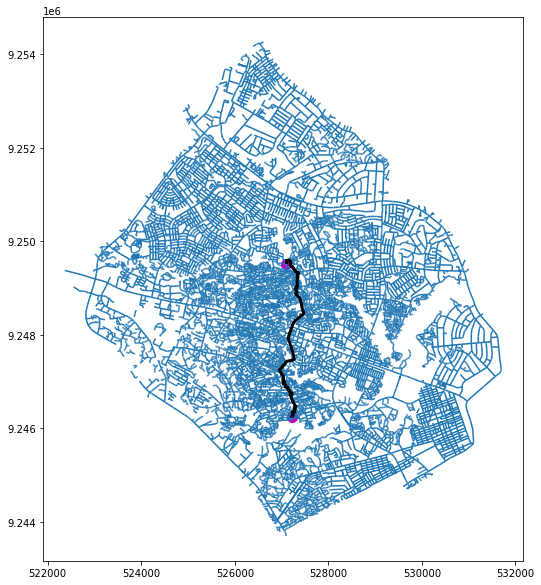

In [8]:
random.seed(2050)
a = list(g.nodes())[random.randint(0,20935)] 
b = list(g.nodes())[random.randint(30000,72935)]

path = nx.algorithms.shortest_paths.weighted.dijkstra_path(g, source= a,
                                                          target= b , weight = 'len')

p = gpd.GeoSeries([shp.geometry.LineString(path)])
po = gpd.GeoSeries([shp.geometry.Point(a),
                   shp.geometry.Point(b)])
                  
p.crs = 32737
po.crs = 32737

ax = roads.plot(figsize = (10,10))
p.plot(ax=ax, color = 'k', linewidth = 3)
po.plot(ax=ax, color = 'm', markersize = 100, alpha = 1)

In [9]:
g.edges(path, data = 'tt_m_max')

EdgeDataView([((527218.7687879023, 9246247.682609797), (527217.0791095891, 9246249.408001218), 0.006037377513978), ((527217.0791095891, 9246249.408001218), (527216.4838017431, 9246252.07248112), 0.006825432486166), ((527217.0791095891, 9246249.408001218), (527192.8359696575, 9246247.950099407), 0.06071734263338), ((527216.4838017431, 9246252.07248112), (527216.9368611445, 9246252.138577892), 0.001144638601173), ((527216.9368611445, 9246252.138577892), (527217.7544775098, 9246252.060777824), 0.002053273866294), ((527217.7544775098, 9246252.060777824), (527218.2849109609, 9246252.182108447), 0.001360332602026), ((527218.2849109609, 9246252.182108447), (527219.1689027487, 9246252.259039886), 0.002218332604744), ((527219.1689027487, 9246252.259039886), (527220.063836727, 9246252.125926953), 0.002261948659922), ((527220.063836727, 9246252.125926953), (527222.1524731488, 9246252.710758273), 0.005422424374277), ((527222.1524731488, 9246252.710758273), (527232.6617039607, 9246255.148474347), 0

In [10]:
list(g.edges(path, data = 'tt_m_max'))[0][2]

0.006037377513978

In [11]:
len(list(g.edges(path, data = 'tt_m_max')))

562

In [12]:
trip_time_min = 0
trip_time_max = 0
path_length = 0
for i in range (len(list(g.edges(path, data = 'tt_m_min')))):
    trip_time_max = trip_time_max + (list(g.edges(path, data = 'tt_m_min'))[i][2])
    trip_time_min = trip_time_min + (list(g.edges(path, data = 'tt_m_max'))[i][2])
    path_length = path_length + (list(g.edges(path, data = 'len'))[i][2])
    
print(trip_time_min)
print(trip_time_max)
print(path_length)

14.604829518188069
15.85322983023956
6385.512631437488


In [13]:
avg_speed = (path_length/1000)/(trip_time_min/60)
avg_speed

26.23315509497176

In [14]:
# after trying several points, the data generated very similar results to google earth maps app
# which indicates that our data is fairly similar

In [15]:
# now we will create a grid shape to cover our study area and from there we will calculate the distance to the nearest 
# cholera treatment center or hospital

In [16]:
# creting the grid function

def create_grid(point,length, x_tiles, y_tiles):
    s = length/np.sqrt(2)
    pol = shp.affinity.rotate((point.buffer(distance = s , resolution= 1)), 45)
    df = gpd.GeoDataFrame({'id': 'box', 'geometry':[pol]})
    df = pd.concat([df]*x_tiles, ignore_index=True)
    for i in range(x_tiles):
        df.at[i,'geometry'] = shp.affinity.translate(df.at[i,'geometry'], xoff = i*length)
    df2 = pd.concat([df]*y_tiles, ignore_index= True)
    for i in range(len(df2)):
        df2.at[i,'geometry'] = shp.affinity.translate(df2.at[i,'geometry'], yoff = (np.floor(i/x_tiles)*length))
    id_list =  [str(x) for x in range(len(df2))]
    id_series = []
    for i in id_list:
        i = 'cell_'+i
        id_series.append(i)
    df2.id = pd.Series(id_series)
    return df2

In [ ]:
# importing the study area as polygons

In [27]:
study_area = gpd.read_file('./output/json/study_area_utm.json.geojson')

In [18]:
study_area.crs

<Projected CRS: EPSG:32737>
Name: WGS 84 / UTM zone 37S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - S hemisphere - 36°E to 42°E - by country
- bounds: (36.0, -80.0, 42.0, 0.0)
Coordinate Operation:
- name: UTM zone 37S
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
study_area.unary_union.bounds

(523059.4263294045, 9243799.81020186, 531140.8605612725, 9254158.300000004)

In [20]:
start_p = shp.geometry.Point(523059.4263294045, 9243799.81020186)

In [21]:
shp.geometry.LineString( [(523059.4263294045, 9243799.81020186) , (531140.8605612725, 9243799.81020186)]).length/100

80.81434231867955

In [22]:
shp.geometry.LineString( [(523059.4263294045, 9243799.81020186) , (523059.4263294045, 9254158.300000004)]).length/100

103.5848979814537

In [23]:
grid = create_grid(start_p, 100, 81,104)

In [24]:
grid.crs = study_area.crs

In [28]:
grid = grid.loc[grid.geometry.intersects(study_area.unary_union)]

In [30]:
grid_points = grid.copy()
grid_points.geometry = grid.geometry.centroid

In [31]:
# now let's get multipoint object of all the nodes in the graph so we can use it to find the closest point to the center of the grid

In [32]:
len(list(g.nodes()))

72934

In [62]:
geom = []
for i in range(len(list(g.nodes()))):
    point = shp.geometry.Point(list(g.nodes())[i])
    geom.append(point)
    
graph_points = gpd.GeoSeries(geom, crs = study_area.crs)

In [63]:
graph_points_frame = gpd.GeoDataFrame(geometry = graph_points, crs =study_area.crs )

In [64]:
graph_points_frame.head()

,geometry
0,POINT (523848.099 9247293.270)
1,POINT (523866.003 9247299.812)
2,POINT (523877.597 9247306.782)
3,POINT (523887.080 9247313.433)
4,POINT (523892.044 9247317.863)


In [65]:
target_points = shp.geometry.MultiPoint([x for x in graph_points_frame.geometry])

In [257]:
n_point = []
for i in range(len(grid_points)):
    m = shp.ops.nearest_points(grid_points.geometry.values[i] , target_points)
    n_point.append((m[1].x,m[1].y))

In [258]:
grid_points['n_point'] = n_point

In [41]:
grid_points.head()

,id,geometry,n_point
40,cell_40,POINT (527059.426 9243799.810),"(527066.7222817108, 9243800.741092134)"
41,cell_41,POINT (527159.426 9243799.810),"(527125.9442472195, 9243865.447112974)"
120,cell_120,POINT (526959.426 9243899.810),"(526963.2601906307, 9243887.4071057)"
121,cell_121,POINT (527059.426 9243899.810),"(527050.1588647763, 9243885.373108672)"
122,cell_122,POINT (527159.426 9243899.810),"(527167.1885009621, 9243884.462209065)"


In [42]:
# now let's get the data for the hospitals and filter only the cholera treatment centres

In [3]:
hospitals = gpd.read_file('./output/json/health.json')

In [4]:
len(hospitals)

613

In [5]:
hospitals.head()

,osm_id,operator,amenity,opening_hours,name,operator:type,health_facility:level,geometry
0,282885265,None,pharmacy,None,Eden Pharmacy,None,None,POINT (39.26376 -6.76966)
1,922241342,None,pharmacy,None,Nakiete,None,None,POINT (39.23230 -6.76742)
2,924363061,None,pharmacy,None,Day and Night Pharmacy,None,None,POINT (39.27121 -6.77844)
3,1393496318,None,pharmacy,None,Phamacy,None,None,POINT (39.24396 -6.79120)
4,1394566410,None,pharmacy,None,None,None,None,POINT (39.24312 -6.79128)


In [6]:
hospitals = hospitals[['amenity','name','geometry']]

In [7]:
# we will filter the hospitals to get only the cholera treatment centers in the study are
# we will also add two more hospitals Amana hospital and Mwanyamala hospital to them
# the selection of hospital is based on the paper published by McCrickard et al 2017

# Citation:
# McCrickard, L. S., Massay, A. E., Narra, R., Mghamba, J.,
# Mohamed, A. A., Kishimba, R. S., Urio, L. J., Rusibayamila, N., Magembe, G., Bakari, M.,
# Gibson, J. J., Eidex, R. B., & Quick, R. E. (2017). Cholera Mortality during Urban Epidemic,
# Tanzania. Emerging Infectious Diseases • Www.Cdc.Gov/Eid, 23(December), 2015–2018. https://doi.org/10.4269/ajtmh.1970.19.653

In [8]:
# Amana Hospital, Mwanyamala Hospital, Temeke CTC at Temeke Hospital,
# Vijibweni CTC, Mburahati CTC at Mburahati Dispensary, and Buguruni CTC

In [9]:
hospitals.dtypes

amenity       object
name          object
geometry    geometry
dtype: object

In [10]:
hospitals.dropna().loc[hospitals.dropna().name.str.contains('Mbu'),:]

,amenity,name,geometry
121,pharmacy,Mburahati Pharmacy,POINT (39.23862 -6.81072)
529,clinic,Mbuyuni Dispensary,POINT (39.24980 -6.79238)
607,clinic,Mburahati Dispensary,POINT (39.24247 -6.80516)


In [11]:
idx = [607]

In [12]:
hospitals.dropna().loc[(hospitals.dropna().name.str.contains('Buguruni Health Centre')),:]

,amenity,name,geometry
490,pharmacy,Mart Buguruni Health Centre,POINT (39.24515 -6.83590)


In [13]:
idx.append(490)

In [14]:
hospitals.dropna().loc[(hospitals.dropna().name.str.contains('Mwa')) ,:]

,amenity,name,geometry
158,clinic,Angaza Mwananyamala Centre,POINT (39.25142 -6.78643)
566,clinic,Mwangula dispensary,POINT (39.23222 -6.78661)
596,hospital,Mwananyamala Hospital,POINT (39.25414 -6.78756)


In [15]:
idx.append(596)

In [16]:
hospitals.dropna().loc[(hospitals.dropna().name.str.contains('mana')) ,:]

,amenity,name,geometry
334,pharmacy,Bhikolomana Pharmacy,POINT (39.24239 -6.82051)
503,hospital,Amana Refferial Hospital,POINT (39.26022 -6.82690)


In [17]:
idx.append(503)

In [18]:
ctc = hospitals.loc[idx]

In [19]:
ctc

,amenity,name,geometry
607,clinic,Mburahati Dispensary,POINT (39.24247 -6.80516)
490,pharmacy,Mart Buguruni Health Centre,POINT (39.24515 -6.83590)
596,hospital,Mwananyamala Hospital,POINT (39.25414 -6.78756)
503,hospital,Amana Refferial Hospital,POINT (39.26022 -6.82690)


In [20]:
# looks  like Buguruni Health Centre is not listed in our dataset, so we will add using the lon, lat data from google earth

In [21]:
ctc.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
ctc.iloc[1,1] = 'Buguruni Health Centre'
ctc.iloc[1,2] = shp.geometry.Point(39.244573,-6.837981)

In [23]:
ctc.iloc[1,0] = 'hospital'

<AxesSubplot:>

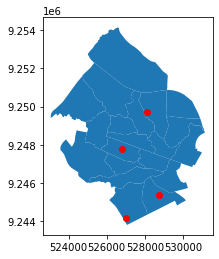

In [28]:
ax = study_area.plot()
ctc.to_crs(study_area.crs).plot(ax=ax, color = 'r')

In [29]:
ctc.to_crs(study_area.crs, inplace = True)

In [31]:
# now, it's time to get the closest point to eah ctc in the graph

In [32]:
ctc.head()

,amenity,name,geometry
607,clinic,Mburahati Dispensary,POINT (526791.585 9247783.049)
490,hospital,Buguruni Health Centre,POINT (527022.629 9244154.845)
596,hospital,Mwananyamala Hospital,POINT (528082.805 9249727.754)
503,hospital,Amana Refferial Hospital,POINT (528752.179 9245378.764)


In [33]:
ctc.to_file('./output/json/ctc.geojson', driver='GeoJSON')

In [66]:
len(target_points)

72934

In [67]:
n_point = []
for i in range(len(ctc)):
    m = shp.ops.nearest_points(ctc.geometry.values[i] , target_points)
    n_point.append((m[1].x,m[1].y))

In [70]:
ctc['n_point'] = n_point

In [73]:
ctc.n_point = ctc.n_point.astype('str')

In [74]:
ctc.to_file('./output/shp/CTC.shp')

In [75]:
grid_points.head()

,id,geometry,n_point
40,cell_40,POINT (527059.426 9243799.810),"(527066.7222817108, 9243800.741092134)"
41,cell_41,POINT (527159.426 9243799.810),"(527125.9442472195, 9243865.447112974)"
120,cell_120,POINT (526959.426 9243899.810),"(526963.2601906307, 9243887.4071057)"
121,cell_121,POINT (527059.426 9243899.810),"(527050.1588647763, 9243885.373108672)"
122,cell_122,POINT (527159.426 9243899.810),"(527167.1885009621, 9243884.462209065)"


In [ ]:
# let's check how a random point will reach the closest ctc

<AxesSubplot:>

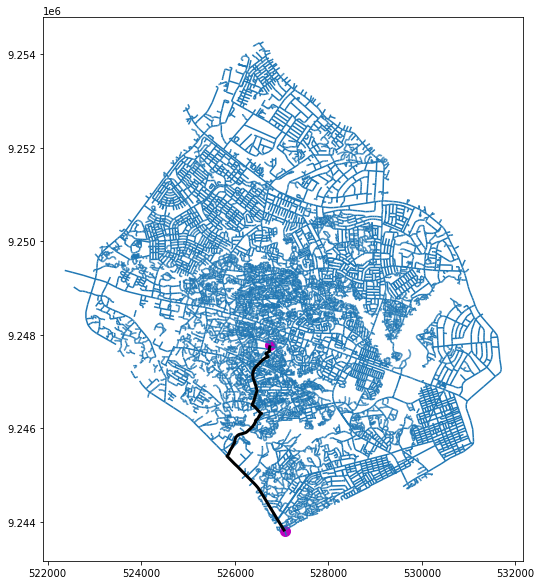

In [76]:
a = (527066.7222817108, 9243800.741092134)
b = (526754.5542010005, 9247776.667286646)

path = nx.algorithms.shortest_paths.weighted.dijkstra_path(g, source= a,
                                                          target= b , weight = 'len')

p = gpd.GeoSeries([shp.geometry.LineString(path)])
po = gpd.GeoSeries([shp.geometry.Point(a),
                   shp.geometry.Point(b)])
                  
p.crs = 32737
po.crs = 32737

ax = roads.plot(figsize = (10,10))
p.plot(ax=ax, color = 'k', linewidth = 3)
po.plot(ax=ax, color = 'm', markersize = 100, alpha = 1)

In [ ]:
# now calculate the time between each point and the closest ctc

In [77]:
trip_time_min = 0
trip_time_max = 0
path_length = 0
for i in range (len(list(g.edges(path, data = 'tt_m_min')))):
    trip_time_max = trip_time_max + (list(g.edges(path, data = 'tt_m_min'))[i][2])
    trip_time_min = trip_time_min + (list(g.edges(path, data = 'tt_m_max'))[i][2])
    path_length = path_length + (list(g.edges(path, data = 'len'))[i][2])
    
print(trip_time_min)
print(trip_time_max)
print(path_length)

13.818845831125115
16.774892246056677
7103.236023172328


In [78]:
list(ctc.n_point.values)

[(526754.5542010005, 9247776.667286646),
 (527060.6440948643, 9244188.885073943),
 (528081.2719872429, 9249733.635605533),
 (528782.6531484881, 9245440.267204609)]

In [79]:
a = (527066.7222817108, 9243800.741092134)
b = list(ctc.n_point.values)

In [264]:
roads.head()

,highway,len,straightne,betweennes,kmh_max,kmh_min,tt_m_max,tt_m_min,geometry
0,primary,19.061221,0.891534,1.008051e-07,45.0,31.0,0.025415,0.036893,"LINESTRING (523848.099 9247293.270, 523866.003..."
1,residential,13.528092,0.904029,1.764088e-07,24.0,16.0,0.033820,0.050730,"LINESTRING (523866.003 9247299.812, 523877.597..."
2,residential,11.583117,0.918325,2.268114e-07,24.0,16.0,0.028958,0.043437,"LINESTRING (523877.597 9247306.782, 523887.080..."
3,residential,6.653189,0.937584,2.520126e-07,24.0,16.0,0.016633,0.024949,"LINESTRING (523887.080 9247313.433, 523892.044..."
4,residential,6.239721,0.943319,2.520126e-07,24.0,24.0,0.015599,0.015599,"LINESTRING (523892.044 9247317.863, 523894.002..."


In [263]:
grid_points.head()

,id,geometry,n_point,n_ctc,tt_ctc
40,cell_40,POINT (527059.426 9243799.810),"(527066.7222817108, 9243800.741092134)","(527060.6440948643, 9244188.885073943)",1.764118
41,cell_41,POINT (527159.426 9243799.810),"(527125.9442472195, 9243865.447112974)","(527060.6440948643, 9244188.885073943)",1.498782
120,cell_120,POINT (526959.426 9243899.810),"(526963.2601906307, 9243887.4071057)","(527060.6440948643, 9244188.885073943)",1.629120
121,cell_121,POINT (527059.426 9243899.810),"(527050.1588647763, 9243885.373108672)","(527060.6440948643, 9244188.885073943)",1.849388
122,cell_122,POINT (527159.426 9243899.810),"(527167.1885009621, 9243884.462209065)","(527060.6440948643, 9244188.885073943)",1.360489


In [82]:
path = nx.algorithms.shortest_paths.weighted.dijkstra_path(g, source= a,
                                                          target= b[0] , weight = 'tt_m_max')

In [83]:
trip_time_min = 0
for i in range (len(list(g.edges(path, data = 'tt_m_max')))):
    trip_time_min = trip_time_max + (list(g.edges(path, data = 'tt_m_max'))[i][2])

trip_time_min

16.847600219415813

In [180]:
# we will only calculate the time to the nearest cholera treatment center

In [181]:
grid_points.head()

,id,geometry,n_point
40,cell_40,POINT (527059.426 9243799.810),"(527066.7222817108, 9243800.741092134)"
41,cell_41,POINT (527159.426 9243799.810),"(527125.9442472195, 9243865.447112974)"
120,cell_120,POINT (526959.426 9243899.810),"(526963.2601906307, 9243887.4071057)"
121,cell_121,POINT (527059.426 9243899.810),"(527050.1588647763, 9243885.373108672)"
122,cell_122,POINT (527159.426 9243899.810),"(527167.1885009621, 9243884.462209065)"


In [182]:
ctc

,amenity,name,geometry,n_point
607,clinic,Mburahati Dispensary,POINT (526791.585 9247783.049),"(526754.5542010005, 9247776.667286646)"
490,hospital,Buguruni Health Centre,POINT (527022.629 9244154.845),"(527060.6440948643, 9244188.885073943)"
596,hospital,Mwananyamala Hospital,POINT (528082.805 9249727.754),"(528081.2719872429, 9249733.635605533)"
503,hospital,Amana Refferial Hospital,POINT (528752.179 9245378.764),"(528782.6531484881, 9245440.267204609)"


In [188]:
target_ctc = shp.geometry.MultiPoint([x for x in ctc.n_point])
n_ctc = []
for i in range(len(grid_points)):
    m = shp.ops.nearest_points(shp.geometry.Point(grid_points.n_point.values[i]) , target_ctc)
    n_ctc.append((m[1].x,m[1].y))

In [190]:
len(n_ctc)

4886

In [191]:
grid_points['n_ctc'] = n_ctc

In [192]:
grid_points

,id,geometry,n_point,n_ctc
40,cell_40,POINT (527059.426 9243799.810),"(527066.7222817108, 9243800.741092134)","(527060.6440948643, 9244188.885073943)"
41,cell_41,POINT (527159.426 9243799.810),"(527125.9442472195, 9243865.447112974)","(527060.6440948643, 9244188.885073943)"
120,cell_120,POINT (526959.426 9243899.810),"(526963.2601906307, 9243887.4071057)","(527060.6440948643, 9244188.885073943)"
121,cell_121,POINT (527059.426 9243899.810),"(527050.1588647763, 9243885.373108672)","(527060.6440948643, 9244188.885073943)"
122,cell_122,POINT (527159.426 9243899.810),"(527167.1885009621, 9243884.462209065)","(527060.6440948643, 9244188.885073943)"
...,...,...,...,...
8298,cell_8298,POINT (526659.426 9253999.810),"(526649.5934763704, 9254006.987233128)","(528081.2719872429, 9249733.635605533)"
8376,cell_8376,POINT (526359.426 9254099.810),"(526392.563771073, 9254176.161214808)","(528081.2719872429, 9249733.635605533)"
8377,cell_8377,POINT (526459.426 9254099.810),"(526455.1373823695, 9254046.514946517)","(528081.2719872429, 9249733.635605533)"
8378,cell_8378,POINT (526559.426 9254099.810),"(526562.1249288794, 9254096.904611314)","(528081.2719872429, 9249733.635605533)"


In [199]:
tt_ctc = []
for x in range(len(grid_points)):
    try:
        path = nx.algorithms.shortest_paths.weighted.dijkstra_path(g, source= grid_points.n_point.values[x],
                                                                   target= grid_points.n_ctc.values[x],
                                                                   weight = 'tt_m_max')

        trip_time = 0
        for i in range (len(list(g.edges(path)))):
            trip_time = trip_time + (list(g.edges(path, data = 'tt_m_max'))[i][2])
    except:
        trip_time = 9999
    tt_ctc.append(trip_time)

In [200]:
len(tt_ctc)

4886

In [205]:
tt_ctc

[1.7641179686899,
 1.49878246604441,
 1.62911958284941,
 1.849388347277824,
 1.3604886426201588,
 1.441937060118584,
 1.56599298118434,
 1.416719715224085,
 0.9493967951153949,
 0.8521149227049157,
 1.2905494201348169,
 1.56599298118434,
 1.718727913752565,
 1.7955972305974781,
 1.3378326343520168,
 1.0241556456478478,
 0.283237442178698,
 0.506365474969758,
 0.6873967542929559,
 1.0521132718417272,
 1.4373208159997568,
 1.825560606442028,
 2.207356094260745,
 2.512175589577557,
 1.7493290842983122,
 1.441355863770379,
 9999,
 0.09855001950492501,
 0.766299309335836,
 1.196006004951991,
 1.1890159298535128,
 1.635952628782101,
 2.0551587550136476,
 2.49740380092608,
 2.8066979082373273,
 3.214852400239678,
 3.8392882430716235,
 1.6301934477004343,
 1.470006944523306,
 1.562681997366738,
 1.291818435892661,
 0.733792058522231,
 1.1267172737245608,
 1.4758297751140468,
 1.5922993138581454,
 2.1680137451620536,
 2.3850434870998063,
 3.023345958298637,
 3.269821934609457,
 3.78887016013412

In [214]:
grid_points['tt_ctc'] = tt_ctc
grid['tt_ctc'] = tt_ctc

<AxesSubplot:>

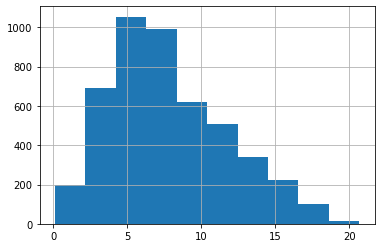

In [207]:
grid_points.loc[grid_points.tt_ctc<9999,'tt_ctc'].hist()

In [208]:
grid_points.loc[grid_points.tt_ctc==9999,'tt_ctc'].value_counts()

9999.0    139
Name: tt_ctc, dtype: int64

In [ ]:
# now lets plot the travel times

<AxesSubplot:>

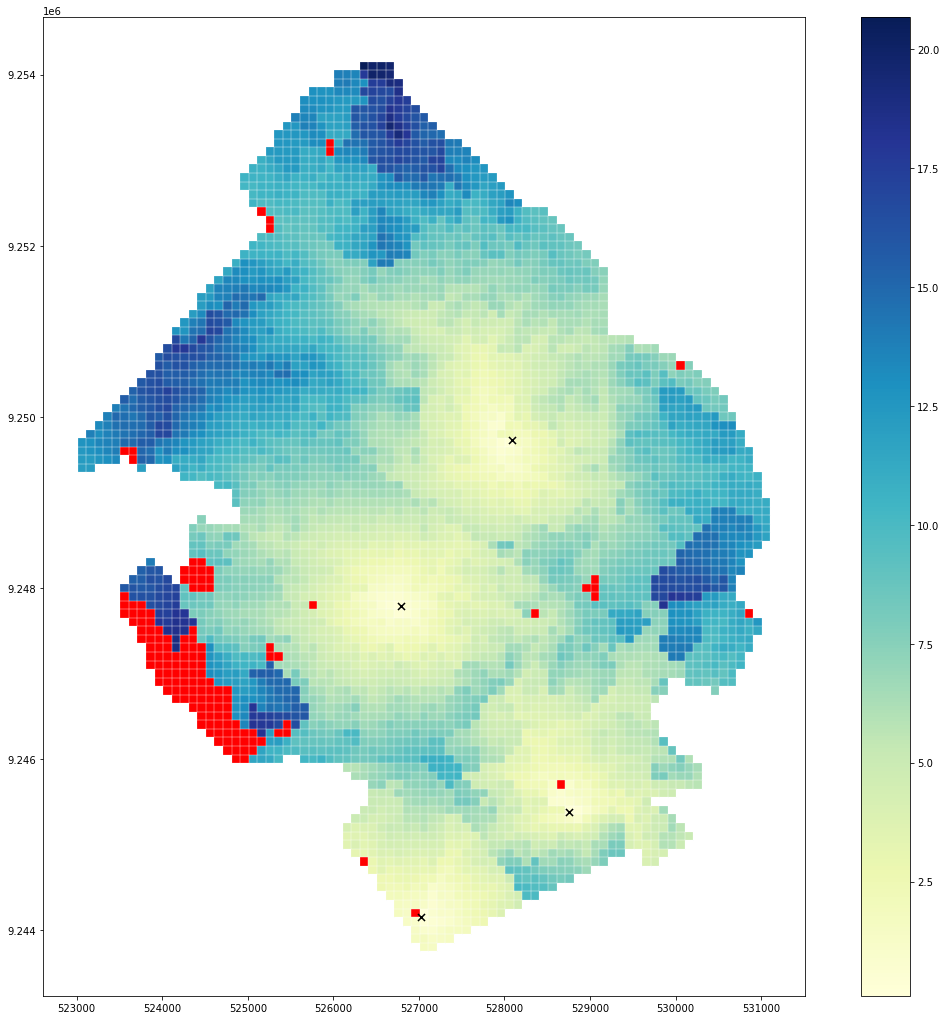

In [238]:
ax = grid.plot(figsize = (20,18), edgecolor = 'w')
grid.loc[grid.tt_ctc==9999].plot(ax=ax, color = 'r')
grid.loc[grid.tt_ctc!=9999].plot(ax=ax,column = 'tt_ctc', cmap = 'YlGnBu', legend = True)
grid.plot(ax=ax, facecolor = 'None',edgecolor = 'w', linewidth=0.2)
ctc.plot(ax=ax, color = 'k', marker = 'x', markersize = 50)


In [269]:
unconnected = grid_points.loc[grid_points.tt_ctc == 9999]

In [270]:
tt_ctc = []
for x in range(len(unconnected)):
    try:
        path = nx.algorithms.shortest_paths.weighted.dijkstra_path(g, source= unconnected.n_point.values[x],
                                                                   target= unconnected.n_ctc.values[x],
                                                                   weight = 'tt_m_max')

        trip_time = 0
        for i in range (len(list(g.edges(path)))):
            trip_time = trip_time + (list(g.edges(path, data = 'tt_m_max'))[i][2])
    except:
        trip_time = 9999
    tt_ctc.append(trip_time)

In [271]:
unconnected.tt_ctc = tt_ctc

C:\Users\aaaa\anaconda3\envs\gis\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [272]:
unconnected.head()

,id,geometry,n_point,n_ctc,tt_ctc
363,cell_363,POINT (526959.426 9244199.810),"(526947.1476599085, 9244229.833970578)","(527060.6440948643, 9244188.885073943)",9999.000000
843,cell_843,POINT (526359.426 9244799.810),"(526356.5511212914, 9244819.189291824)","(527060.6440948643, 9244188.885073943)",9999.000000
1595,cell_1595,POINT (528659.426 9245699.810),"(528619.4463278642, 9245772.415805897)","(528782.6531484881, 9245440.267204609)",9999.000000
1800,cell_1800,POINT (524859.426 9245999.810),"(525029.238880505, 9246216.87375826)","(526754.5542010005, 9247776.667286646)",12.820499
1801,cell_1801,POINT (524959.426 9245999.810),"(525107.578747823, 9246145.932352558)","(526754.5542010005, 9247776.667286646)",12.963327


In [274]:
grid_points.loc[unconnected.index,'tt_ctc']=unconnected.tt_ctc
grid.loc[unconnected.index,'tt_ctc']=unconnected.tt_ctc

In [276]:
grid.to_file('./output/shp/travel_times_grid.shp')

In [285]:
grid_points['tt_ctc_traffic']= tt_ctc_traffic
grid['tt_ctc_traffic']= tt_ctc_traffic

In [77]:
plt.rcParams['figure.facecolor'] = 'white'

In [115]:
ctc = gpd.read_file('./output/shp/CTC.shp')

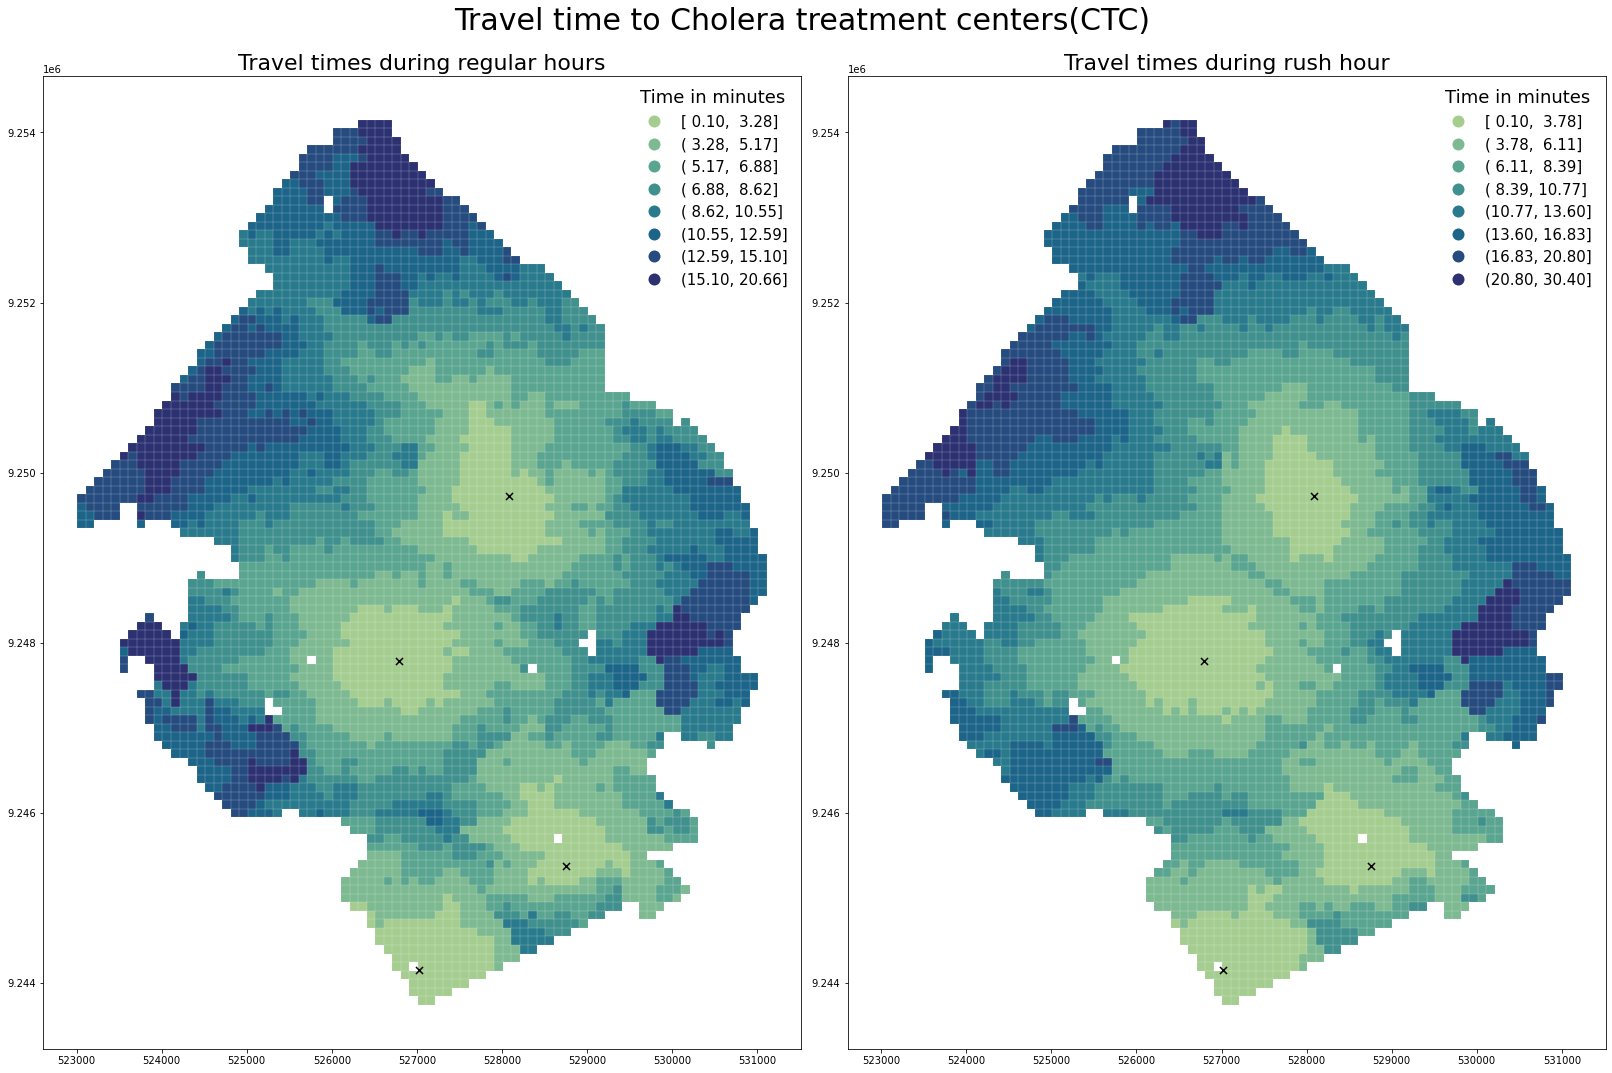

In [114]:
fig, ax = plt.subplots(1,2, figsize = (1.5*15,1.5*10))

#plot the first one
grid.loc[grid.tt_ctc==9999].plot(ax=ax[0], color = 'w')
grid.loc[grid.tt_ctc!=9999].plot(ax=ax[0] ,column = 'tt_ctc',
                                 scheme = 'naturalbreaks', k = 8,cmap = 'crest',
                                 legend = True, legend_kwds =  {'fontsize':15,'title_fontsize': 18,
                                                               'title': 'Time in minutes', 'markerscale':1.2,
                                                               'frameon' : False})
grid.plot(ax=ax[0] , facecolor = 'None',edgecolor = 'w', linewidth=0.1)
ctc.plot(ax=ax[0] , color = 'k', marker = 'x', markersize = 50)

#plot the second one
grid.loc[grid.tt_ctc==9999].plot(ax=ax[1], color = 'w')
grid.loc[grid.tt_ctc!=9999].plot(ax=ax[1] ,column = 'tt_ctc_tra',
                                 scheme = 'naturalbreaks', k = 8, cmap = 'crest',
                                 legend = True, legend_kwds = {'fontsize':15,'title_fontsize': 18,
                                                               'title': 'Time in minutes', 'markerscale':1.2,
                                                               'frameon' : False})
grid.plot(ax=ax[1] , facecolor = 'None',edgecolor = 'w', linewidth=0.1)
ctc.plot(ax=ax[1] , color = 'k', marker = 'x', markersize = 50)

fig.suptitle("Travel time to Cholera treatment centers(CTC) \n ", fontsize=1.5*20)
ax[0].set_title('Travel times during regular hours', fontsize=22)
ax[1].set_title('Travel times during rush hour', fontsize=22)

plt.tight_layout()
plt.savefig('./output/jpg/03.jpg', dpi=150)